Using device: cuda
STARTING ENHANCED PLUME-ONLY TRAINING (v2)

TRAINING ENHANCED MODEL ON PLUME
Model capacity increased: res=96, skip=192, cycles=3
Applying low-pass filter to PID data (cutoff=330Hz)...
Filtering complete.
Fitting data scalers (MinMaxScaler)...
Scalers fitted.
Using max learning rate: 0.001

--- Epoch 1/200 ---
Losses (Train/Val): 2.101167/1.061547 | MAEs (Train/Val): 0.312291/0.140488
New best model saved with validation loss: 1.061547

--- Epoch 2/200 ---
Losses (Train/Val): 0.913006/0.947163 | MAEs (Train/Val): 0.116254/0.121570
New best model saved with validation loss: 0.947163

--- Epoch 3/200 ---
Losses (Train/Val): 0.783947/0.811398 | MAEs (Train/Val): 0.094602/0.099020
New best model saved with validation loss: 0.811398

--- Epoch 4/200 ---
Losses (Train/Val): 0.716553/0.771699 | MAEs (Train/Val): 0.083466/0.092511
New best model saved with validation loss: 0.771699

--- Epoch 5/200 ---
Losses (Train/Val): 0.670104/0.687156 | MAEs (Train/Val): 0.075812/0.0784

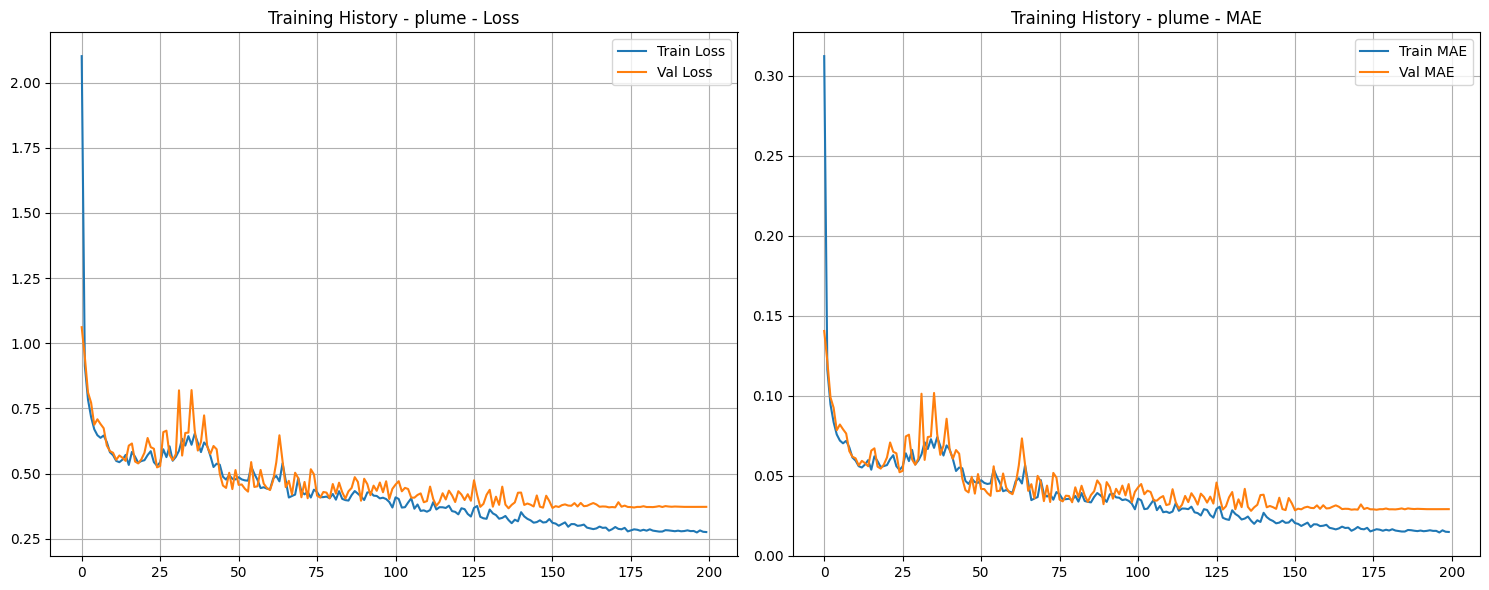

C:\Users\ackel\AppData\Local\Temp\ipykernel_99124\1816419038.py:322: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Generating enhanced comparison plots for PLUME...


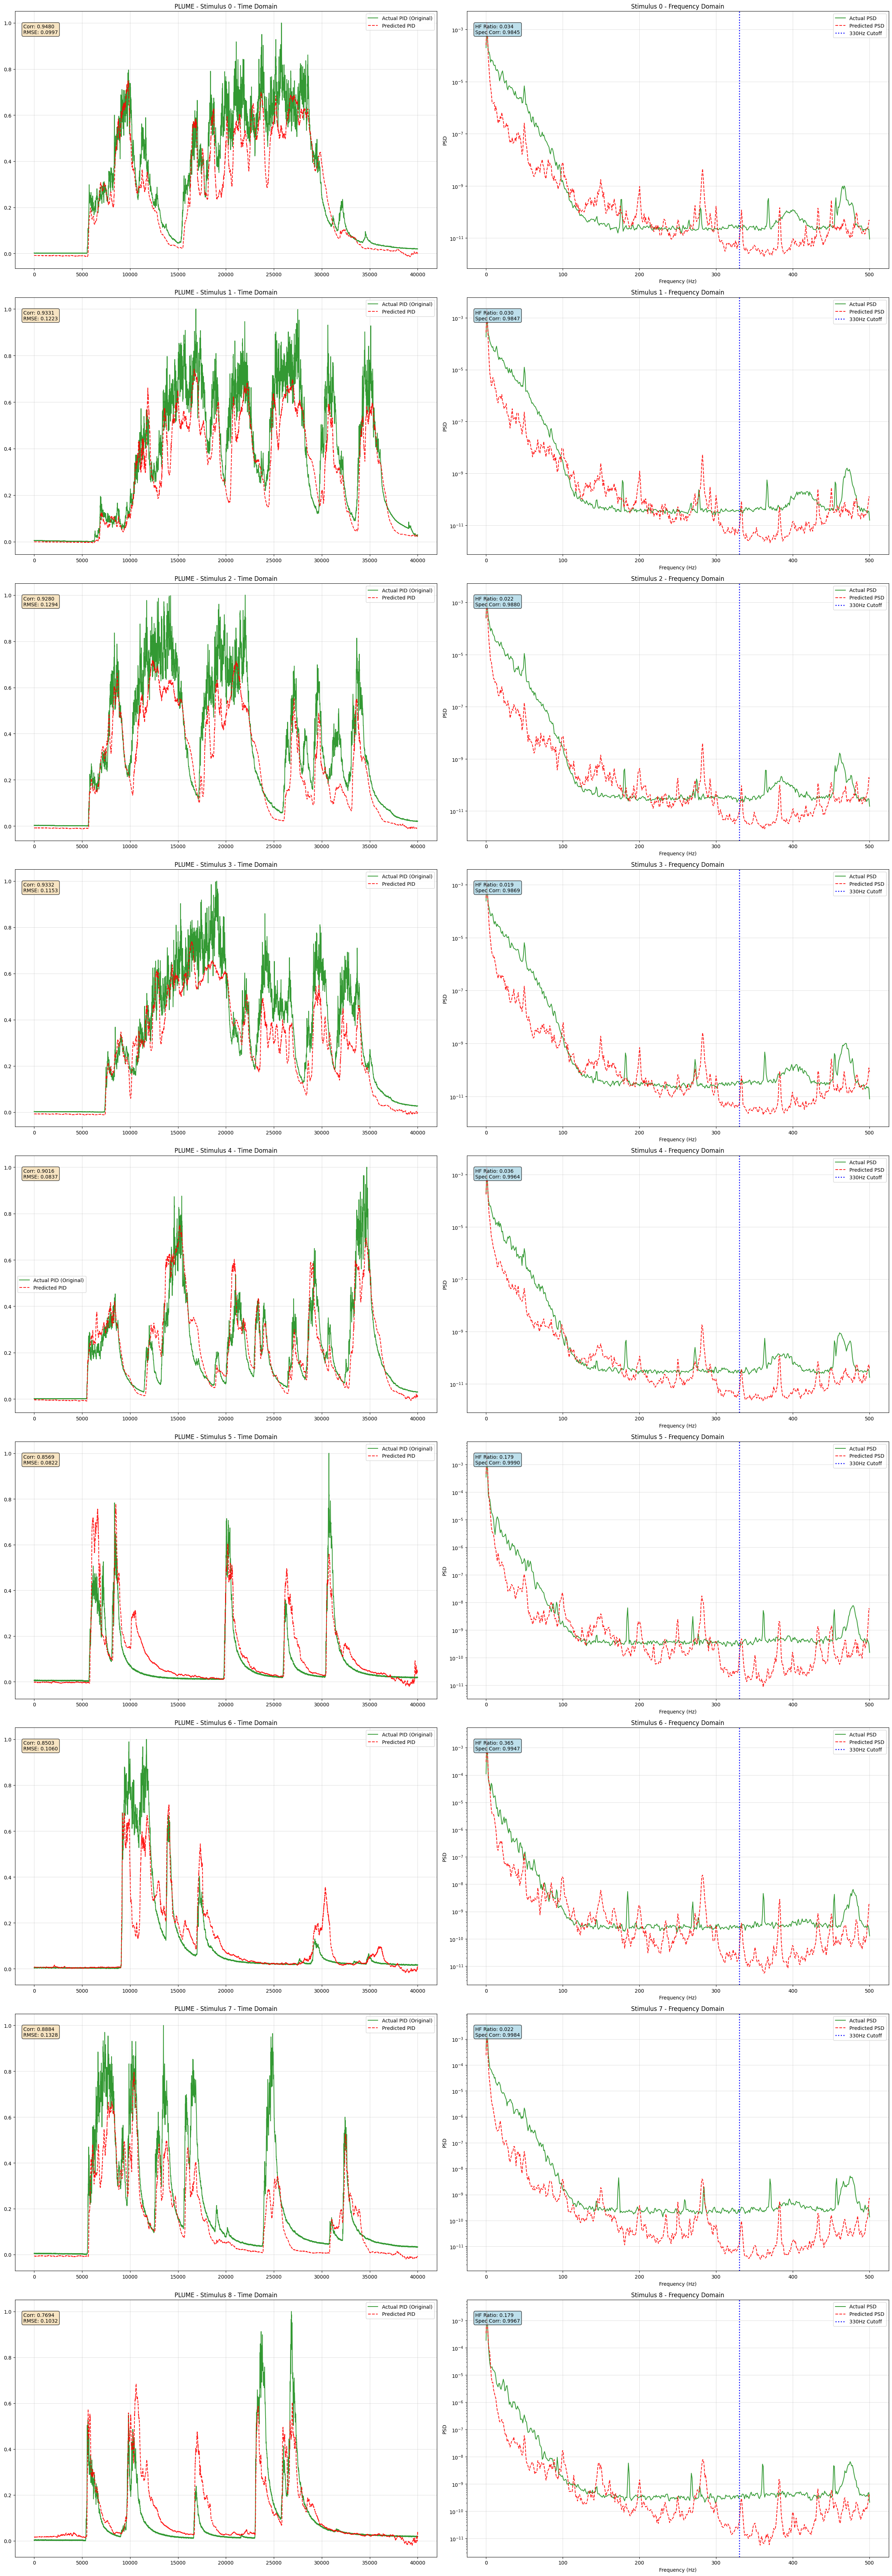


PLUME TRAINING COMPLETE! Final model saved as 'final_plume_model_v2.pth'.

Check 'models_wavenet_style_AT_enhanced_v2' for models and plots.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import OneCycleLR
from torchaudio.transforms import Spectrogram
import os
import glob
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import signal
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


PID_DATA_DIR = "E:\\CNN data\\PID\\AT_normalised"
MICS_DATA_DIR = "E:\\CNN data\\MICS\\AT_normalised"
N_REPEATS = 5
INITIAL_EPOCHS = 200
BATCH_SIZE = 4
MODEL_SAVE_DIR = "models_wavenet_style_AT_enhanced_v2"
MIN_SEQUENCE_LENGTH = 256
MAX_SEQUENCE_LENGTH = 10000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)


mics_scaler = MinMaxScaler(feature_range=(-1, 1))
pid_scaler = MinMaxScaler(feature_range=(-1, 1))


def apply_low_pass_filter(data, cutoff_hz, fs=1000, order=4):
    """
    Applies a Butterworth low-pass filter to the signal.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_hz / nyquist
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    filtered_data = signal.sosfilt(sos, data)
    return filtered_data


class FrequencyShapeLoss(nn.Module):
    def __init__(self, mse_weight=1.5, derivative_weight=1.0, envelope_weight=1.5,
                 stft_weight=0.5, multi_res_hf_weight=0.75, spectral_corr_weight=0.2):
        super(FrequencyShapeLoss, self).__init__()
        self.mse_weight = mse_weight
        self.derivative_weight = derivative_weight
        self.envelope_weight = envelope_weight
        self.stft_weight = stft_weight
        self.multi_res_hf_weight = multi_res_hf_weight
        self.spectral_corr_weight = spectral_corr_weight
        self.l1_loss = nn.L1Loss(reduction='none')
        self.stft_losses = nn.ModuleList([
            Spectrogram(n_fft=1024, hop_length=256, power=2).to(device),
            Spectrogram(n_fft=512, hop_length=128, power=2).to(device),
            Spectrogram(n_fft=256, hop_length=64, power=2).to(device)
        ])
        self.envelope_filter = nn.Conv1d(1, 1, kernel_size=31, padding=15, bias=False, padding_mode='replicate').to(device)
        torch.nn.init.constant_(self.envelope_filter.weight, 1.0 / 31.0)
        for param in self.envelope_filter.parameters():
            param.requires_grad = False

    def forward(self, y_pred, y_true, lengths):
        max_len = y_true.size(2)
        mask = torch.arange(max_len, device=lengths.device)[None, :] < lengths[:, None]
        mask = mask.unsqueeze(1).float()
        time_loss = self.l1_loss(y_pred, y_true)
        masked_time_loss = torch.sum(time_loss * mask) / torch.sum(mask)
        pred_diff = torch.diff(y_pred, dim=2, prepend=y_pred[:, :, :1])
        true_diff = torch.diff(y_true, dim=2, prepend=y_true[:, :, :1])
        deriv_loss = self.l1_loss(pred_diff, true_diff)
        masked_deriv_loss = torch.sum(deriv_loss * mask) / torch.sum(mask)
        pred_envelope = self.envelope_filter(y_pred)
        true_envelope = self.envelope_filter(y_true)
        envelope_loss = self.l1_loss(pred_envelope, true_envelope)
        masked_envelope_loss = torch.sum(envelope_loss * mask) / torch.sum(mask)
        stft_loss, multi_res_hf_loss, spectral_corr_loss = 0.0, 0.0, 0.0
        for stft in self.stft_losses:
            pred_spec = stft(y_pred.squeeze(1))
            true_spec = stft(y_true.squeeze(1))
            log_pred_spec = torch.log1p(pred_spec)
            log_true_spec = torch.log1p(true_spec)
            stft_loss += F.l1_loss(log_pred_spec, log_true_spec)
            freq_bins = pred_spec.size(1)
            high_freq_start = int(freq_bins * 0.2)
            multi_res_hf_loss += F.l1_loss(log_pred_spec[:, high_freq_start:, :], log_true_spec[:, high_freq_start:, :])
            pred_mean = torch.mean(log_pred_spec, dim=-1, keepdim=True)
            true_mean = torch.mean(log_true_spec, dim=-1, keepdim=True)
            pred_std = torch.std(log_pred_spec, dim=-1, keepdim=True)
            true_std = torch.std(log_true_spec, dim=-1, keepdim=True)
            cov = torch.mean((log_pred_spec - pred_mean) * (log_true_spec - true_mean), dim=-1, keepdim=True)
            corr = cov / (pred_std * true_std + 1e-6)
            spectral_corr_loss += torch.mean(1 - corr)
        stft_loss /= len(self.stft_losses)
        multi_res_hf_loss /= len(self.stft_losses)
        spectral_corr_loss /= len(self.stft_losses)
        total_loss = (self.mse_weight * masked_time_loss +
                      self.derivative_weight * masked_deriv_loss +
                      self.envelope_weight * masked_envelope_loss +
                      self.stft_weight * stft_loss +
                      self.multi_res_hf_weight * multi_res_hf_loss +
                      self.spectral_corr_weight * spectral_corr_loss)
        return total_loss


class WaveNetResidualBlock(nn.Module):
    def __init__(self, res_channels, skip_channels, kernel_size, dilation):
        super(WaveNetResidualBlock, self).__init__()
        self.dilated_conv = nn.Conv1d(res_channels, 2 * res_channels, kernel_size,
                                      padding=(kernel_size - 1) * dilation,
                                      dilation=dilation, padding_mode='replicate')
        self.res_conv = nn.Conv1d(res_channels, res_channels, 1)
        self.skip_conv = nn.Conv1d(res_channels, skip_channels, 1)

    def forward(self, x):
        residual = x
        x_dilated = self.dilated_conv(x)
        x_dilated = x_dilated[:, :, :residual.size(2)]
        out_tanh, out_sigmoid = torch.chunk(x_dilated, 2, dim=1)
        gated_activation = torch.tanh(out_tanh) * torch.sigmoid(out_sigmoid)
        res_out = self.res_conv(gated_activation)
        skip_out = self.skip_conv(gated_activation)
        return res_out + residual, skip_out

class WaveNetModel(nn.Module):
    def __init__(self, in_channels=1, res_channels=64, skip_channels=128,
                 num_blocks=10, num_cycles=2, kernel_size=3):
        super(WaveNetModel, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, res_channels, kernel_size=1, padding_mode='replicate')
        self.residual_blocks = nn.ModuleList()
        for _ in range(num_cycles):
            for i in range(num_blocks):
                dilation = 2**i
                self.residual_blocks.append(
                    WaveNetResidualBlock(res_channels, skip_channels, kernel_size, dilation))
        self.final_conv1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.final_conv2 = nn.Conv1d(skip_channels, 1, 1)

    def forward(self, x, lengths=None):
        x = self.initial_conv(x)
        skip_connections = []
        for block in self.residual_blocks:
            x, skip = block(x)
            skip_connections.append(skip)
        total_skip = sum(skip_connections)
        out = F.relu(total_skip)
        out = self.final_conv1(out)
        out = F.relu(out)
        out = self.final_conv2(out)
        return out


class VariableLengthSignalDataset(Dataset):
    def __init__(self, mics_data, pid_data, min_length=MIN_SEQUENCE_LENGTH, max_length=MAX_SEQUENCE_LENGTH, is_train=False):
        self.is_train = is_train
        self.mics_data, self.pid_data, self.lengths = [], [], []
        for mics, pid in zip(mics_data, pid_data):
            if len(mics) < min_length: continue
            if len(mics) > max_length: mics, pid = mics[:max_length], pid[:max_length]
            min_len = min(len(mics), len(pid))
            mics, pid = mics[:min_len], pid[:min_len]
            mics_norm = mics_scaler.transform(mics.reshape(-1, 1)).flatten()
            mics_delta = np.gradient(mics_norm)
            mics_delta2 = np.gradient(mics_delta)
            mics_features = np.stack([mics_norm, mics_delta, mics_delta2], axis=1)
            pid_norm = pid_scaler.transform(pid.reshape(-1, 1)).flatten()
            self.mics_data.append(torch.FloatTensor(mics_features))
            self.pid_data.append(torch.FloatTensor(pid_norm))
            self.lengths.append(min_len)

    def __len__(self): return len(self.mics_data)

    def __getitem__(self, idx):
        mics_features = self.mics_data[idx]
        pid_signal = self.pid_data[idx]
        length = self.lengths[idx]
        if self.is_train:
            scale_factor = torch.tensor(np.random.uniform(0.95, 1.05), dtype=torch.float32)
            mics_features = mics_features * scale_factor
            pid_signal = pid_signal * scale_factor
            noise_level = 0.005
            mics_noise = torch.randn(mics_features.shape) * noise_level
            mics_features = mics_features + mics_noise
        return mics_features.T, pid_signal, length

def collate_variable_length(batch):
    mics_seq, pid_seq, lengths = zip(*batch)
    mics_padded = pad_sequence(mics_seq, batch_first=True)
    pid_padded = pad_sequence(pid_seq, batch_first=True).unsqueeze(1)
    return mics_padded, pid_padded, torch.tensor(lengths)


def train_epoch_variable_length(model, train_loader, criterion, optimizer, scheduler, device):
    model.train(); total_loss, total_mae, num_batches = 0, 0, len(train_loader)
    for mics_b, pid_b, lengths in train_loader:
        mics_b, pid_b, lengths = mics_b.to(device), pid_b.to(device), lengths.to(device)
        optimizer.zero_grad(); outputs = model(mics_b); loss = criterion(outputs, pid_b, lengths)
        loss.backward(); optimizer.step(); scheduler.step(); total_loss += loss.item()
        mae=0
        for i, length in enumerate(lengths):
            pred_dn = pid_scaler.inverse_transform(outputs[i,:,:length].detach().cpu().numpy().T).T
            true_dn = pid_scaler.inverse_transform(pid_b[i,:,:length].cpu().numpy().T).T
            mae += F.l1_loss(torch.tensor(pred_dn), torch.tensor(true_dn)).item()
        total_mae += mae/len(lengths)
    return total_loss / num_batches, total_mae / num_batches

def validate_epoch_variable_length(model, val_loader, criterion, device):
    model.eval(); total_loss, total_mae = 0, 0
    with torch.no_grad():
        for mics_b, pid_b, lengths in val_loader:
            mics_b, pid_b, lengths = mics_b.to(device), pid_b.to(device), lengths.to(device)
            outputs = model(mics_b); total_loss += criterion(outputs, pid_b, lengths).item()
            mae=0
            for i, length in enumerate(lengths):
                pred_dn = pid_scaler.inverse_transform(outputs[i,:,:length].cpu().numpy().T).T
                true_dn = pid_scaler.inverse_transform(pid_b[i,:,:length].cpu().numpy().T).T
                mae += F.l1_loss(torch.tensor(pred_dn), torch.tensor(true_dn)).item()
            total_mae += mae/len(lengths)
    return total_loss / len(val_loader), total_mae / len(val_loader)


def detect_stimulus_files(pid_dir, mics_dir, stimulus_type):
    pid_files = glob.glob(os.path.join(pid_dir, f"PID_{stimulus_type}_AT*.npy"))
    mics_files = glob.glob(os.path.join(mics_dir, f"MICS_{stimulus_type}_AT*.npy"))
    stimulus_data = defaultdict(lambda: {'pid': [], 'mics': []})
    for f in pid_files:
        m = re.search(r'AT\[(\d+)\]\[(\d+)\]', os.path.basename(f))
        if m: stimulus_data[int(m.group(1))]['pid'].append((int(m.group(2)), f))
    for f in mics_files:
        m = re.search(r'AT\[(\d+)\]\[(\d+)\]', os.path.basename(f))
        if m: stimulus_data[int(m.group(1))]['mics'].append((int(m.group(2)), f))
    organized_data = {}
    for idx in sorted(stimulus_data.keys()):
        if len(stimulus_data[idx]['pid']) == N_REPEATS and len(stimulus_data[idx]['mics']) == N_REPEATS:
            organized_data[idx] = {
                'pid_files': [f for _, f in sorted(stimulus_data[idx]['pid'])],
                'mics_files': [f for _, f in sorted(stimulus_data[idx]['mics'])]
            }
    return organized_data

def load_stimulus_data(stimulus_files):
    pid_d = [np.load(f) for f in stimulus_files['pid_files']]
    mics_d = [np.load(f) for f in stimulus_files['mics_files']]
    return pid_d, mics_d


def train_stimulus_type_variable_length(stimulus_type):
    print(f"\n{'='*50}\nTRAINING ENHANCED MODEL ON {stimulus_type.upper()}\n{'='*50}")
    stimulus_files = detect_stimulus_files(PID_DATA_DIR, MICS_DATA_DIR, stimulus_type)
    if not stimulus_files:
        print(f"No files found for stimulus type: {stimulus_type}")
        return None

    model = WaveNetModel(in_channels=3, res_channels=96, skip_channels=192,
                         num_blocks=10, num_cycles=3, kernel_size=3).to(device)
    print("Model capacity increased: res=96, skip=192, cycles=3")

    all_pid_data, all_mics_data = [], []
    for idx in sorted(stimulus_files.keys()):
        pid_d, mics_d = load_stimulus_data(stimulus_files[idx])
        all_pid_data.extend(pid_d)
        all_mics_data.extend(mics_d)


    print("Applying low-pass filter to PID data (cutoff=330Hz)...")
    filtered_pid_data = [apply_low_pass_filter(pid, cutoff_hz=330) for pid in all_pid_data]
    print("Filtering complete.")

    print("Fitting data scalers (MinMaxScaler)...")
    mics_scaler.fit(np.concatenate([s.flatten() for s in all_mics_data]).reshape(-1, 1))
    pid_scaler.fit(np.concatenate([s.flatten() for s in filtered_pid_data]).reshape(-1, 1))
    print("Scalers fitted.")

    mics_train, mics_val, pid_train, pid_val = train_test_split(
        all_mics_data, filtered_pid_data, test_size=0.2, random_state=42
    )

    train_dataset = VariableLengthSignalDataset(mics_train, pid_train, is_train=True)
    val_dataset = VariableLengthSignalDataset(mics_val, pid_val, is_train=False)

    if len(train_dataset) == 0 or len(val_dataset) == 0:
        print("Dataset is empty after splitting. Cannot train.")
        return None

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_variable_length)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_variable_length)

    criterion = FrequencyShapeLoss().to(device)
    max_lr = 1e-3
    print(f"Using max learning rate: {max_lr}")

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=INITIAL_EPOCHS)

    history = defaultdict(list); best_val_loss = float('inf')
    for epoch in range(INITIAL_EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{INITIAL_EPOCHS} ---")
        train_loss, train_mae = train_epoch_variable_length(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss, val_mae = validate_epoch_variable_length(model, val_loader, criterion, device)
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae); history['val_mae'].append(val_mae)
        print(f"Losses (Train/Val): {train_loss:.6f}/{val_loss:.6f} | MAEs (Train/Val): {train_mae:.6f}/{val_mae:.6f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(MODEL_SAVE_DIR, f'best_model_{stimulus_type}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with validation loss: {best_val_loss:.6f}")

    plot_enhanced_training_history(history['train_loss'], history['val_loss'], history['train_mae'], history['val_mae'], stimulus_type)
    model.load_state_dict(torch.load(best_model_path))
    plot_full_signal_comparison(model, stimulus_type, stimulus_files)
    return model

def plot_enhanced_training_history(tl, vl, tm, vm, st):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)); title=f'Training History - {st}'
    ax1.plot(tl, label='Train Loss'); ax1.plot(vl, label='Val Loss'); ax1.set_title(f'{title} - Loss'); ax1.legend(); ax1.grid(True)
    ax2.plot(tm, label='Train MAE'); ax2.plot(vm, label='Val MAE'); ax2.set_title(f'{title} - MAE'); ax2.legend(); ax2.grid(True)
    plt.tight_layout(); plt.savefig(os.path.join(MODEL_SAVE_DIR, title.replace(' ', '_').lower() + '.png')); plt.show()

def predict_full_sequence_variable_length(model, mics_signal):
    model.eval()
    mics_norm = mics_scaler.transform(mics_signal.reshape(-1, 1)).flatten()
    mics_delta = np.gradient(mics_norm)
    mics_delta2 = np.gradient(mics_delta)
    mics_features = np.stack([mics_norm, mics_delta, mics_delta2], axis=1)
    mics_tensor = torch.FloatTensor(mics_features).T.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_norm = model(mics_tensor).cpu().numpy().squeeze()
    return pid_scaler.inverse_transform(pred_norm.reshape(-1, 1)).flatten()

def compute_frequency_metrics(y_true, y_pred, fs=1000, hf_threshold=50):
    freqs, psd_true = signal.welch(y_true, fs, nperseg=1024)
    _, ps_pred = signal.welch(y_pred, fs, nperseg=1024)
    spectral_corr = np.corrcoef(psd_true, ps_pred)[0, 1]
    peak_freq_true = freqs[np.argmax(psd_true)]
    peak_freq_pred = freqs[np.argmax(ps_pred)]
    peak_freq_error = abs(peak_freq_true - peak_freq_pred)
    hf_mask = freqs > hf_threshold
    hf_power_true = np.sum(psd_true[hf_mask])
    hf_power_pred = np.sum(ps_pred[hf_mask])
    hf_power_ratio = hf_power_pred / (hf_power_true + 1e-9)
    return {"frequencies": freqs, "psd_true": psd_true, "psd_pred": ps_pred,
            "spectral_correlation": spectral_corr, "peak_freq_error": peak_freq_error,
            "hf_power_ratio": hf_power_ratio}

def plot_full_signal_comparison(model, stimulus_type, stimulus_files):
    print(f"\nGenerating enhanced comparison plots for {stimulus_type.upper()}...")
    model.eval()
    stimuli_to_plot = sorted(stimulus_files.keys())[:10]
    n_plots = len(stimuli_to_plot)
    if n_plots == 0: return

    fig, axes = plt.subplots(n_plots, 2, figsize=(25, 8 * n_plots), squeeze=False)
    for i, idx in enumerate(stimuli_to_plot):
        pid_data, mics_data = load_stimulus_data(stimulus_files[idx])
        full_pid_original, full_mics = pid_data[0], mics_data[0]
        pred_pid = predict_full_sequence_variable_length(model, full_mics)
        min_len = min(len(full_pid_original), len(pred_pid))
        t = np.arange(min_len)
        ax_time = axes[i, 0]
        ax_time.plot(t, full_pid_original[:min_len], 'g-', alpha=0.8, label='Actual PID (Original)', linewidth=1.5)
        ax_time.plot(t, pred_pid[:min_len], 'r--', alpha=0.9, label='Predicted PID', linewidth=1.5)
        ax_time.set_title(f'{stimulus_type.upper()} - Stimulus {idx} - Time Domain')
        ax_time.legend(); ax_time.grid(True, alpha=0.4)
        time_corr = np.corrcoef(full_pid_original[:min_len], pred_pid[:min_len])[0, 1]
        rmse = np.sqrt(np.mean((full_pid_original[:min_len] - pred_pid[:min_len])**2))
        ax_time.text(0.02, 0.95, f'Corr: {time_corr:.4f}\nRMSE: {rmse:.4f}', transform=ax_time.transAxes, va='top', bbox=dict(boxstyle='round', fc='wheat', alpha=0.8))
        
        freq_metrics = compute_frequency_metrics(full_pid_original[:min_len], pred_pid[:min_len])
        ax_freq = axes[i, 1]
        ax_freq.semilogy(freq_metrics['frequencies'], freq_metrics['psd_true'], 'g-', label='Actual PSD', alpha=0.8)
        ax_freq.semilogy(freq_metrics['frequencies'], freq_metrics['psd_pred'], 'r--', label='Predicted PSD', alpha=0.9)
        ax_freq.axvline(330, color='b', linestyle=':', linewidth=2, label='330Hz Cutoff')
        ax_freq.set_title(f'Stimulus {idx} - Frequency Domain')
        ax_freq.set_xlabel('Frequency (Hz)'); ax_freq.set_ylabel('PSD')
        ax_freq.legend(); ax_freq.grid(True, alpha=0.4)
        ax_freq.text(0.02, 0.95, f'HF Ratio: {freq_metrics["hf_power_ratio"]:.3f}\nSpec Corr: {freq_metrics["spectral_correlation"]:.4f}', transform=ax_freq.transAxes, va='top', bbox=dict(boxstyle='round', fc='lightblue', alpha=0.8))
        
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, f'enhanced_comparison_{stimulus_type}.png'), dpi=300)
    plt.show()


def train_plume_only():
    print("="*60 + "\nSTARTING ENHANCED PLUME-ONLY TRAINING (v2)\n" + "="*60)
    model = train_stimulus_type_variable_length(stimulus_type="plume")
    if model:
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, "final_plume_model_v2.pth"))
        print(f"\nPLUME TRAINING COMPLETE! Final model saved as 'final_plume_model_v2.pth'.")

if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        
    train_plume_only()
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    print(f"\nCheck '{MODEL_SAVE_DIR}' for models and plots.")